**Lecture 10: Classification with Multilayer Perceptron**

In [1]:
%matplotlib inline
import os
import tqdm
import time
import torch
import pickle
import numpy as np
from torch import nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset,DataLoader

print(torch.__version__) # This code has been updated for PyTorch 1.0.0


savePath = 'lecture10_output/'
if not os.path.isdir(savePath):
    os.makedirs(savePath)

1.13.1+cu116


**Loading saved features**

In [3]:
with open("trainFeats.pckl", "rb") as f:
    trainFeats = pickle.load(f)
with open("trainLabel.pckl", "rb") as f:
    trainLabel = pickle.load(f)
    
with open("testFeats.pckl", "rb") as f:
    testFeats = pickle.load(f)
with open("testLabel.pckl", "rb") as f:
    testLabel = pickle.load(f)

**Defining network architecture**

In [4]:
class mlp(nn.Module):
    def __init__(self,n_channels): #n_channels => length of feature vector
        super(mlp, self).__init__()
        self.L1 = nn.Linear(n_channels,6) #Mapping from input to hidden layer       
        self.L2 = nn.Linear(6,10) #Mapping from hidden layer to output
    def forward(self,x): #x => Input
        x = self.L1(x) #Feed-forward  
        x = F.relu(x) #Sigmoid non-linearity
        x = self.L2(x) #Feed-forward           
        x = F.softmax(x,dim=1) #Sigmoid non-linearity
        return x

**Dataset preparation**

In [5]:
# Generating 1-hot label vectors
trainLabel2 = np.zeros((50000,10))
for d1 in range(trainLabel.shape[0]):
    trainLabel2[d1,trainLabel[d1]] = 1

In [6]:
# Checking availability of GPU
use_gpu = torch.cuda.is_available()
if use_gpu:
    print('GPU is available!')
    device = "cuda"
    pinMem = True
else:
    print('GPU is not available!')
    device = "cpu"
    pinMem = False

GPU is available!


In [7]:
# Creating pytorch dataset from the feature matices
trainDataset = TensorDataset(torch.from_numpy(trainFeats), torch.from_numpy(trainLabel2))
testDataset = TensorDataset(torch.from_numpy(testFeats), torch.from_numpy(testLabel))
# Creating dataloader
trainLoader = DataLoader(trainDataset, batch_size=64, shuffle=True,num_workers=4, pin_memory=pinMem)
testLoader = DataLoader(testDataset, batch_size=64, shuffle=False,num_workers=4, pin_memory=pinMem)

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


**Defining function for training the network**

In [8]:
# Definining the training routine
def train_model(model,criterion,num_epochs,learning_rate):
        start = time.time()
        train_loss = [] #List for saving the loss per epoch     
        
        for epoch in range(num_epochs):
            epochStartTime = time.time()
            print('Epoch {}/{}'.format(epoch, num_epochs - 1))

            running_loss = 0.0           
            # Loading data in batches
            batch = 0
            for data in tqdm.tqdm_notebook(trainLoader):
                inputs,labels = data
                
                inputs, labels = inputs.float().to(device),labels.float().to(device)
                
                # Initializing model gradients to zero
                model.zero_grad() 
                # Data feed-forward through the network
                outputs = model(inputs)
                # Predicted class is the one with maximum probability
                _, preds = torch.max(outputs.data, 1)
                # Finding the MSE
                loss = criterion(outputs, labels)
                # Accumulating the loss for each batch
                running_loss += loss.item()
                # Backpropaging the error
                if batch == 0:
                    totalLoss = loss
                    totalPreds = preds
                    batch += 1                    
                else:
                    totalLoss += loss
                    totalPreds = torch.cat((totalPreds,preds),0)  
                    batch += 1
                    
            totalLoss = totalLoss/batch
            totalLoss.backward()
            
            # Updating the model parameters
            for f in model.parameters():
                f.data.sub_(f.grad.data * learning_rate)                
           
            epoch_loss = running_loss/50000  #Total loss for one epoch
            train_loss.append(epoch_loss) #Saving the loss over epochs for plotting the graph           
            
            print('Epoch loss: {:.6f}'.format(epoch_loss))
            epochTimeEnd = time.time()-epochStartTime
            print('Epoch complete in {:.0f}m {:.0f}s'.format(
            epochTimeEnd // 60, epochTimeEnd % 60))
            print('-' * 25)
            # Plotting Loss vs Epochs
            fig1 = plt.figure(1)        
            plt.plot(range(epoch+1),train_loss,'r--',label='train')        
            if epoch==0:
                plt.legend(loc='upper left')
                plt.xlabel('Epochs')
                plt.ylabel('Loss')
                plt.title('Plot of training loss vs epochs')
            fig1.savefig(savePath+'mlp_lossPlot.png')             

        time_elapsed = time.time() - start
        print('Training complete in {:.0f}m {:.0f}s'.format(
            time_elapsed // 60, time_elapsed % 60))
        return model

**Model initialization and training**

Epoch 0/99


<ipython-input-8-c37b4e46d8ba>:13: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for data in tqdm.tqdm_notebook(trainLoader):


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch loss: 0.001417
Epoch complete in 0m 5s
-------------------------
Epoch 1/99


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch loss: 0.001417
Epoch complete in 0m 3s
-------------------------
Epoch 2/99


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch loss: 0.001416
Epoch complete in 0m 3s
-------------------------
Epoch 3/99


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch loss: 0.001416
Epoch complete in 0m 3s
-------------------------
Epoch 4/99


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch loss: 0.001416
Epoch complete in 0m 2s
-------------------------
Epoch 5/99


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch loss: 0.001415
Epoch complete in 0m 2s
-------------------------
Epoch 6/99


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch loss: 0.001415
Epoch complete in 0m 2s
-------------------------
Epoch 7/99


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch loss: 0.001415
Epoch complete in 0m 2s
-------------------------
Epoch 8/99


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch loss: 0.001414
Epoch complete in 0m 2s
-------------------------
Epoch 9/99


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch loss: 0.001414
Epoch complete in 0m 2s
-------------------------
Epoch 10/99


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch loss: 0.001414
Epoch complete in 0m 2s
-------------------------
Epoch 11/99


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch loss: 0.001414
Epoch complete in 0m 2s
-------------------------
Epoch 12/99


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch loss: 0.001413
Epoch complete in 0m 2s
-------------------------
Epoch 13/99


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch loss: 0.001413
Epoch complete in 0m 2s
-------------------------
Epoch 14/99


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch loss: 0.001413
Epoch complete in 0m 2s
-------------------------
Epoch 15/99


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch loss: 0.001413
Epoch complete in 0m 2s
-------------------------
Epoch 16/99


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch loss: 0.001412
Epoch complete in 0m 2s
-------------------------
Epoch 17/99


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch loss: 0.001412
Epoch complete in 0m 2s
-------------------------
Epoch 18/99


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch loss: 0.001412
Epoch complete in 0m 2s
-------------------------
Epoch 19/99


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch loss: 0.001412
Epoch complete in 0m 2s
-------------------------
Epoch 20/99


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch loss: 0.001412
Epoch complete in 0m 2s
-------------------------
Epoch 21/99


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch loss: 0.001411
Epoch complete in 0m 2s
-------------------------
Epoch 22/99


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch loss: 0.001411
Epoch complete in 0m 2s
-------------------------
Epoch 23/99


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch loss: 0.001411
Epoch complete in 0m 2s
-------------------------
Epoch 24/99


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch loss: 0.001411
Epoch complete in 0m 2s
-------------------------
Epoch 25/99


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch loss: 0.001411
Epoch complete in 0m 2s
-------------------------
Epoch 26/99


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch loss: 0.001411
Epoch complete in 0m 2s
-------------------------
Epoch 27/99


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch loss: 0.001410
Epoch complete in 0m 2s
-------------------------
Epoch 28/99


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch loss: 0.001410
Epoch complete in 0m 2s
-------------------------
Epoch 29/99


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch loss: 0.001410
Epoch complete in 0m 2s
-------------------------
Epoch 30/99


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch loss: 0.001410
Epoch complete in 0m 3s
-------------------------
Epoch 31/99


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch loss: 0.001410
Epoch complete in 0m 3s
-------------------------
Epoch 32/99


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch loss: 0.001410
Epoch complete in 0m 2s
-------------------------
Epoch 33/99


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch loss: 0.001410
Epoch complete in 0m 2s
-------------------------
Epoch 34/99


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch loss: 0.001409
Epoch complete in 0m 2s
-------------------------
Epoch 35/99


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch loss: 0.001409
Epoch complete in 0m 2s
-------------------------
Epoch 36/99


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch loss: 0.001409
Epoch complete in 0m 2s
-------------------------
Epoch 37/99


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch loss: 0.001409
Epoch complete in 0m 2s
-------------------------
Epoch 38/99


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch loss: 0.001409
Epoch complete in 0m 2s
-------------------------
Epoch 39/99


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch loss: 0.001409
Epoch complete in 0m 2s
-------------------------
Epoch 40/99


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch loss: 0.001409
Epoch complete in 0m 2s
-------------------------
Epoch 41/99


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch loss: 0.001409
Epoch complete in 0m 2s
-------------------------
Epoch 42/99


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch loss: 0.001409
Epoch complete in 0m 3s
-------------------------
Epoch 43/99


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch loss: 0.001409
Epoch complete in 0m 2s
-------------------------
Epoch 44/99


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch loss: 0.001408
Epoch complete in 0m 2s
-------------------------
Epoch 45/99


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch loss: 0.001408
Epoch complete in 0m 2s
-------------------------
Epoch 46/99


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch loss: 0.001408
Epoch complete in 0m 2s
-------------------------
Epoch 47/99


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch loss: 0.001408
Epoch complete in 0m 2s
-------------------------
Epoch 48/99


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch loss: 0.001408
Epoch complete in 0m 2s
-------------------------
Epoch 49/99


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch loss: 0.001408
Epoch complete in 0m 2s
-------------------------
Epoch 50/99


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch loss: 0.001408
Epoch complete in 0m 2s
-------------------------
Epoch 51/99


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch loss: 0.001408
Epoch complete in 0m 2s
-------------------------
Epoch 52/99


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch loss: 0.001408
Epoch complete in 0m 2s
-------------------------
Epoch 53/99


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch loss: 0.001408
Epoch complete in 0m 2s
-------------------------
Epoch 54/99


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch loss: 0.001408
Epoch complete in 0m 2s
-------------------------
Epoch 55/99


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch loss: 0.001408
Epoch complete in 0m 2s
-------------------------
Epoch 56/99


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch loss: 0.001407
Epoch complete in 0m 2s
-------------------------
Epoch 57/99


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch loss: 0.001407
Epoch complete in 0m 2s
-------------------------
Epoch 58/99


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch loss: 0.001407
Epoch complete in 0m 2s
-------------------------
Epoch 59/99


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch loss: 0.001407
Epoch complete in 0m 2s
-------------------------
Epoch 60/99


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch loss: 0.001407
Epoch complete in 0m 3s
-------------------------
Epoch 61/99


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch loss: 0.001407
Epoch complete in 0m 2s
-------------------------
Epoch 62/99


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch loss: 0.001407
Epoch complete in 0m 2s
-------------------------
Epoch 63/99


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch loss: 0.001407
Epoch complete in 0m 2s
-------------------------
Epoch 64/99


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch loss: 0.001407
Epoch complete in 0m 2s
-------------------------
Epoch 65/99


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch loss: 0.001407
Epoch complete in 0m 2s
-------------------------
Epoch 66/99


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch loss: 0.001407
Epoch complete in 0m 2s
-------------------------
Epoch 67/99


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch loss: 0.001407
Epoch complete in 0m 2s
-------------------------
Epoch 68/99


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch loss: 0.001407
Epoch complete in 0m 2s
-------------------------
Epoch 69/99


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch loss: 0.001407
Epoch complete in 0m 2s
-------------------------
Epoch 70/99


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch loss: 0.001407
Epoch complete in 0m 2s
-------------------------
Epoch 71/99


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch loss: 0.001407
Epoch complete in 0m 2s
-------------------------
Epoch 72/99


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch loss: 0.001407
Epoch complete in 0m 2s
-------------------------
Epoch 73/99


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch loss: 0.001407
Epoch complete in 0m 2s
-------------------------
Epoch 74/99


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch loss: 0.001407
Epoch complete in 0m 2s
-------------------------
Epoch 75/99


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch loss: 0.001407
Epoch complete in 0m 2s
-------------------------
Epoch 76/99


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch loss: 0.001407
Epoch complete in 0m 2s
-------------------------
Epoch 77/99


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch loss: 0.001407
Epoch complete in 0m 2s
-------------------------
Epoch 78/99


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch loss: 0.001407
Epoch complete in 0m 2s
-------------------------
Epoch 79/99


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch loss: 0.001407
Epoch complete in 0m 2s
-------------------------
Epoch 80/99


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch loss: 0.001406
Epoch complete in 0m 2s
-------------------------
Epoch 81/99


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch loss: 0.001406
Epoch complete in 0m 2s
-------------------------
Epoch 82/99


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch loss: 0.001406
Epoch complete in 0m 2s
-------------------------
Epoch 83/99


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch loss: 0.001406
Epoch complete in 0m 2s
-------------------------
Epoch 84/99


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch loss: 0.001406
Epoch complete in 0m 3s
-------------------------
Epoch 85/99


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch loss: 0.001406
Epoch complete in 0m 2s
-------------------------
Epoch 86/99


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch loss: 0.001406
Epoch complete in 0m 2s
-------------------------
Epoch 87/99


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch loss: 0.001406
Epoch complete in 0m 2s
-------------------------
Epoch 88/99


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch loss: 0.001406
Epoch complete in 0m 2s
-------------------------
Epoch 89/99


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch loss: 0.001406
Epoch complete in 0m 2s
-------------------------
Epoch 90/99


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch loss: 0.001406
Epoch complete in 0m 2s
-------------------------
Epoch 91/99


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch loss: 0.001406
Epoch complete in 0m 2s
-------------------------
Epoch 92/99


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch loss: 0.001406
Epoch complete in 0m 2s
-------------------------
Epoch 93/99


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch loss: 0.001406
Epoch complete in 0m 2s
-------------------------
Epoch 94/99


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch loss: 0.001406
Epoch complete in 0m 2s
-------------------------
Epoch 95/99


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch loss: 0.001406
Epoch complete in 0m 2s
-------------------------
Epoch 96/99


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch loss: 0.001406
Epoch complete in 0m 2s
-------------------------
Epoch 97/99


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch loss: 0.001406
Epoch complete in 0m 2s
-------------------------
Epoch 98/99


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch loss: 0.001406
Epoch complete in 0m 2s
-------------------------
Epoch 99/99


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch loss: 0.001406
Epoch complete in 0m 2s
-------------------------
Training complete in 4m 3s


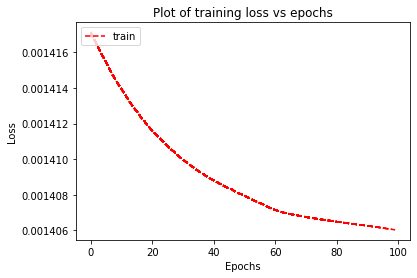

In [9]:
feat_length = 2+5+2
model = mlp(feat_length).to(device) # Initilaizing the model
criterion = nn.MSELoss() 
model = train_model(model,criterion,num_epochs=100,learning_rate=10) # Training the model

**Evaluation of trained model**

In [10]:
# Finding testing accuracy
test_running_corr = 0
# Loading data in batches
batches = 0

model.eval() # Testing the model in evaluation mode

for tsData in tqdm.tqdm_notebook(testLoader):
    inputs,_ = tsData
    
    inputs = inputs.float().to(device)
    
    with torch.no_grad(): # No back-propagation during testing; gradient computation is not required
    
        # Feedforward train data batch through model
        output = model(inputs) 
        # Predicted class is the one with maximum probability
        _,preds = output.data.max(1)    
        if batches==0:
            totalPreds = preds
            batches = 1
        else:
            totalPreds = torch.cat((totalPreds,preds),0)

ts_corr = np.sum(np.equal(totalPreds.cpu().numpy(),testLabel))
ts_acc = ts_corr/testLabel.shape[0]
print('Testing accuracy = '+str(ts_acc*100)+'%')

<ipython-input-10-e0c628c98990>:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for tsData in tqdm.tqdm_notebook(testLoader):


  0%|          | 0/157 [00:00<?, ?it/s]

Testing accuracy = 10.66%
